In [2]:
#python implementation similar to matlab
#load matlab data
import scipy.io
data = scipy.io.loadmat("data.mat")

x1 = data['data']['x1'][0][0]
x2 = data['data']['x2'][0][0]
x3 = data['data']['x3'][0][0]
K  = data['data']['K'][0][0]
img1 = data['data']['img1'][0][0]
img2 = data['data']['img2'][0][0]

#debug purposes : prints the variables as in debugger
from pprint import pprint
#pprint(data)
print K

[[568.99614085   0.         643.21055941]
 [  0.         568.9883624  477.98280104]
 [  0.           0.           1.        ]]


In [3]:
#https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py
import numpy as np
np.set_printoptions(precision = 4,suppress=True)
import cv2
def createA_matrix(x1, x2):
    A = np.ones((len(x1),9), dtype=np.float32)
    for i in range(len(x1)):
        A[i][0]=x1[i][0] * x2[i][0] #x' * x
        A[i][1]=x1[i][0] * x2[i][1] #x' * y
        A[i][2]=x1[i][0]                 #x'
        A[i][3]=x1[i][1] * x2[i][0] #y' * x
        A[i][4]=x1[i][1] * x2[i][1] #y' * y
        A[i][5]=x1[i][1]                 #y'
        A[i][6]=x2[i][0]                 #x
        A[i][7]=x2[i][1]                 #y
        A[i][8]=1    
    return A

def getF(A):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    v = vh.transpose() #unlike matlab, we need to transpose it
    last_col_of_v = v[:,-1]
    F = last_col_of_v.reshape((3,3))
    u_, s_, vh_ = np.linalg.svd(F)
    s_last_zero = s_
    s_last_zero[2] = 0
    F_prime = np.dot( np.dot(u_, np.diag(s_last_zero)),vh_)
    F_prime = np.divide(F_prime, np.linalg.norm(F_prime))
    #F_prime = np.divide(F_prime,F[2,2])
    return F_prime

#https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py
def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] """
    x1 = x1.transpose()
    x2 = x2.transpose()
    x1 = np.insert(x1, 2, np.ones(x1.shape[1]), axis=0)
    x2 = np.insert(x2, 2, np.ones(x2.shape[1]), axis=0)
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    # v = vh.transpose();last_col_of_v = v[:,-1]  #unlike matlab, we need to transpose it
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]

def essentialFromFundamental2(F,K):
    E_b = K.transpose().dot(F).dot(K)
    U,S,V = np.linalg.svd(E_b)
    S = np.diag(S)
    S = S/S[0,0]
    S[2,2] = 0
    S[1,1] = 1
    
    E = np.dot(np.dot(U,S), V) 
    return E

In [4]:
A = createA_matrix(x1,x2)
F = getF(A)
F2 = compute_fundamental(x1,x2)

print F
print F2
print "difference between those two methods is: F_prime = np.divide(F_prime,F[2,2])"

[[-0.      0.     -0.0026]
 [-0.      0.     -0.0015]
 [ 0.0037  0.0031 -1.    ]]
[[ 0.     -0.      0.0026]
 [ 0.     -0.      0.0015]
 [-0.0037 -0.0031  1.    ]]
difference between those two methods is: F_prime = np.divide(F_prime,F[2,2])


In [5]:
E = essentialFromFundamental2(F,K)
E2 = essentialFromFundamental2(F2,K)
print E
print E2

[[-0.0191  0.3676 -0.1265]
 [-0.5325  0.0077 -0.8365]
 [ 0.1391  0.9194 -0.0235]]
[[ 0.0191 -0.3676  0.1265]
 [ 0.5325 -0.0077  0.8365]
 [-0.1391 -0.9194  0.0235]]


In [6]:
def skew(v):
    if len(v) == 4: v = v[:3]/v[3]
    skv = np.roll(np.roll(np.diag(v.flatten()), 1, 1), -1, 0)
    return skv - skv.T

def compute_P_from_essential(E):
    """    Computes the second camera matrix (assuming P1 = [I 0]) 
        from an essential matrix. Output is a list of four 
        possible camera matrices. """
    
    #coursera minute 11:27 epipolar geometry 3
    # make sure E is rank 2
    U,S,V = np.linalg.svd(E)
    if np.linalg.det(np.dot(U,V))<0:
        V = -V
    E = np.dot(U,np.dot(np.diag([1,1,0]),V))    
    
    # create matrices (Hartley p 258)
    Z = skew(np.array([0,0,-1]))
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    
    # return all four solutions
    P2 = [np.vstack((np.dot(U,np.dot(W,V)).T,U[:,2])).T,
             np.vstack((np.dot(U,np.dot(W,V)).T,-U[:,2])).T,
            np.vstack((np.dot(U,np.dot(W.T,V)).T,U[:,2])).T,
            np.vstack((np.dot(U,np.dot(W.T,V)).T,-U[:,2])).T]

    return P2

Pset = compute_P_from_essential(E)
Pset2 = compute_P_from_essential(E2)
print Pset
print ""
print Pset2


def decomposeEIntoRandC(E):
    return np.linalg.qr(E, mode='complete')

print "nope, QR decomposition was used to find K from E or F, i think F, because E is allready stripped of K"
print  "QR decomposition of F"
Q,R_d = decomposeEIntoRandC(F)
print Q
print R_d
print K


[array([[ 0.9824, -0.0131, -0.1864,  0.9211],
       [ 0.0134,  0.9999,  0.0006, -0.129 ],
       [ 0.1864, -0.0031,  0.9825, -0.3673]]), array([[ 0.9824, -0.0131, -0.1864, -0.9211],
       [ 0.0134,  0.9999,  0.0006,  0.129 ],
       [ 0.1864, -0.0031,  0.9825,  0.3673]]), array([[ 0.5554, -0.2447, -0.7948,  0.9211],
       [-0.2288, -0.9638,  0.1368, -0.129 ],
       [-0.7995,  0.1059, -0.5913, -0.3673]]), array([[ 0.5554, -0.2447, -0.7948, -0.9211],
       [-0.2288, -0.9638,  0.1368,  0.129 ],
       [-0.7995,  0.1059, -0.5913,  0.3673]])]

[array([[ 0.9824, -0.0131, -0.1864,  0.9211],
       [ 0.0134,  0.9999,  0.0006, -0.129 ],
       [ 0.1864, -0.0031,  0.9825, -0.3673]]), array([[ 0.9824, -0.0131, -0.1864, -0.9211],
       [ 0.0134,  0.9999,  0.0006,  0.129 ],
       [ 0.1864, -0.0031,  0.9825,  0.3673]]), array([[ 0.5554, -0.2447, -0.7948,  0.9211],
       [-0.2288, -0.9638,  0.1368, -0.129 ],
       [-0.7995,  0.1059, -0.5913, -0.3673]]), array([[ 0.5554, -0.2447, -0.7948, -0.

In [7]:

def triangulate_V2(x1,x2,P1,P2):
    #https://github.com/WenjinTao/Robotics--Coursera/blob/master/Robotics-Perception/Week_4/RoboticsPerceptionWeek4AssignmentCode/LinearTriangulation.m
    Xtrian = []
    for i in range(len(x1)):
        x_1 =np.array([x1[i][0], x1[i][1], x1[i][2], 1])
        x_2 =np.array([x2[i][0], x2[i][1], x2[i][2], 1])
        
        skew1 = skew(x_1)
        skew2 = skew(x_2)
        A = np.zeros((6, 4))
        A[:3,:] = np.dot(skew1, P1)
        A[3:6,:] = np.dot(skew2, P2)

        U,S,V = np.linalg.svd(A)

        X = V[-1,:4]
        Xtrian.append(X / X[3])

    #return X / X[3]
    return Xtrian

def getXset(x1, x2, Pset ):
    P1 = np.eye(3)
    P1 = K.dot(np.insert(P1, 3, -P1.dot(np.zeros(3)), axis=1))######################################
    x_1 = np.array([x1[0][0], x1[0][1],1])
    x_2 = np.array([x2[0][0], x2[0][1],1])
    vector_of_ones  = np.ones((x1.shape[0],))
    x_1 = np.insert(x1, 2, vector_of_ones ,axis = 1)
    x_2 = np.insert(x2, 2, vector_of_ones ,axis = 1)
    
    Xset = []

    for P in Pset:
        X = triangulate_V2(x_1,x_2, P1, P)
        Xset.append(X)  
    return Xset

Xset = getXset(x1,x2,Pset)
Xset2 = getXset(x1,x2,Pset2)

In [8]:
def disambiguateCameraPose(Pset, Xset): #Xset is triangulation in 3d
    #Epipolar geometry coursera minute 23:44
    n = []
    
    for i in range(len(Xset)): #for each of the four camera poses
        X = np.array(Xset[i])
        P = Pset[i]
        R = P[:,:3]
        C = P[:,[3]] # keeps whe dimension info otherwise it would be (30,)
        #https://github.com/WenjinTao/Robotics--Coursera/blob/master/Robotics-Perception/Week_4/RoboticsPerceptionWeek4AssignmentCode/DisambiguateCameraPose.m
        #print len(X)
        #print C.shape
        aux = np.dot(C, np.ones((1,len(X)))) 
        #print aux.shape
        D = np.dot(R, X[:,:3].transpose() - aux) 
        #print "Dshape", D.shape
        #print (D[2,:] > 0).shape # & X[:3].transpose() > 0
        #print (X[:,3].transpose() > 0).shape
        truth_table = (D[2,:] > 0) & (X[:,3].transpose() > 0)
        positives = [x for x in truth_table if x==True]
        n.append(len(positives))
        #print len(positives)
    idx = max(range(len(n)), key = lambda i: n[i])
    return Pset[idx], Xset[idx]

def getRFromP(P):
    return P[:,:3]

def getCFromP(P):
    return P[:,[3]]

P, X = disambiguateCameraPose(Pset, Xset)
P2, X2 = disambiguateCameraPose(Pset2, Xset2)
R = getRFromP(P)
C = getCFromP(P)
print R
print C
R = getRFromP(P2)
C = getCFromP(P2)
print R
print C

print "\ntransposed version, correct version from run_sfm.m line 18, 19"
R = R.T
C = -C
R2 = R
C2 = C

[[ 0.9824 -0.0131 -0.1864]
 [ 0.0134  0.9999  0.0006]
 [ 0.1864 -0.0031  0.9825]]
[[ 0.9211]
 [-0.129 ]
 [-0.3673]]
[[ 0.9824 -0.0131 -0.1864]
 [ 0.0134  0.9999  0.0006]
 [ 0.1864 -0.0031  0.9825]]
[[ 0.9211]
 [-0.129 ]
 [-0.3673]]

transposed version, correct version from run_sfm.m line 18, 19


In [9]:
print np.array(X)
print np.array(X2)


[[ 0.5062  0.4387  0.4767  1.    ]
 [ 0.3432  0.004   0.1988  1.    ]
 [-0.5058 -0.2895  0.8199  1.    ]
 ...
 [ 0.5182  0.0239  0.1869  1.    ]
 [ 0.3781 -0.0413  0.1826  1.    ]
 [-0.0223 -0.1152  0.2195  1.    ]]
[[ 0.5062  0.4387  0.4767  1.    ]
 [ 0.3432  0.004   0.1988  1.    ]
 [-0.5058 -0.2895  0.8199  1.    ]
 ...
 [ 0.5182  0.0239  0.1869  1.    ]
 [ 0.3781 -0.0413  0.1826  1.    ]
 [-0.0223 -0.1152  0.2195  1.    ]]


In [10]:
def triangulate_V2(x1,x2,P1,P2):
    #https://github.com/WenjinTao/Robotics--Coursera/blob/master/Robotics-Perception/Week_4/RoboticsPerceptionWeek4AssignmentCode/LinearTriangulation.m
    Xtrian = []
    for i in range(len(x1)):
        x_1 =np.array([x1[i][0], x1[i][1], x1[i][2], 1])
        x_2 =np.array([x2[i][0], x2[i][1], x2[i][2], 1])
        
        skew1 = skew(x_1)
        skew2 = skew(x_2)
        A = np.zeros((6, 4))
        A[:3,:] = np.dot(skew1, P1)
        A[3:6,:] = np.dot(skew2, P2)

        #the formulas are explained in epipolar geometry 3
        # minute 18:04
        # so if you have projections from multiple cameras, you can get a better reconstruction
        # minte 19:54 point triangulation could be done easier with stereo configuration with -C translation

        U,S,V = np.linalg.svd(A)

        X = V[-1,:4]
        Xtrian.append(X / X[3])

    #return X / X[3]
    return Xtrian

P1 = np.eye(3)
P1 = K.dot(np.insert(P1, 3, -P1.dot(np.zeros(3)), axis=1))######################################
#P2 - np.insert(R,  3, C[:,0],           axis=1)
P2 = K.dot(np.insert(R, 3, -(R.dot(C[:,0])), axis=1))######################################

##########################################
print "\n\n###################################"
print "later add"
print "P2",P2
P2_v2 = K.dot(np.insert(R, 3, -(R.dot(C[:,0])), axis=1)) 
print "P2_v2",P2_v2

print "stripped of K"
print "P2 stripped ok K",np.linalg.inv(K).dot(P2)
print "P2_v2 stripped ok K",np.linalg.inv(K).dot(P2_v2)
print "##################################\n\n"
###########################################

vector_of_ones  = np.ones((x1.shape[0],))
x_1 = np.insert(x1, 2, vector_of_ones ,axis = 1)
x_2 = np.insert(x2, 2, vector_of_ones ,axis = 1)
X = triangulate_V2(x_1,x_2,P1,P2)
X = np.array(X)

print x_1[0]
print (P1.dot(X.T)[:,0])
print np.cross(x_1[0],(P1.dot(X.T)[:,0]))
print "the above should be actually be 0 but because of noise, it is not. the second vector is a multiple of  7.5086 of the first"

#P1.dot(X.T)[:,0]



###################################
later add
P2 [[ 439.0603    8.05    737.9957  132.361 ]
 [ -96.5427  569.2444  467.82   -334.1874]
 [  -0.1864    0.0006    0.9825   -0.5326]]
P2_v2 [[ 439.0603    8.05    737.9957  132.361 ]
 [ -96.5427  569.2444  467.82   -334.1874]
 [  -0.1864    0.0006    0.9825   -0.5326]]
stripped of K
P2 stripped ok K [[ 0.9824  0.0134  0.1864  0.8347]
 [-0.0131  0.9999 -0.0031 -0.1399]
 [-0.1864  0.0006  0.9825 -0.5326]]
P2_v2 stripped ok K [[ 0.9824  0.0134  0.1864  0.8347]
 [-0.0131  0.9999 -0.0031 -0.1399]
 [-0.1864  0.0006  0.9825 -0.5326]]
##################################


[717.52 576.13   1.  ]
[5381.9102 4321.3846    7.5086]
[ 4.5551 -5.6729 -0.0086]
the above should be actually be 0 but because of noise, it is not. the second vector is a multiple of  7.5086 of the first


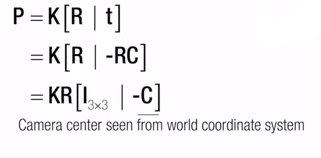
taken from coursera epipolar geometry 3 minute 24:35
ok so this is the formula to compute P



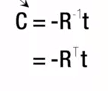
C is computed from t
and t represents translation from C1 to C2 as seen by C1
and C represents the translation from C2 to C1 as seen by C2 maybe??

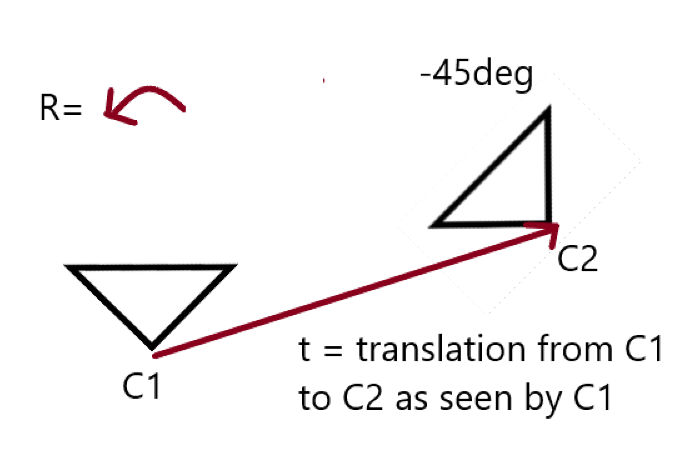

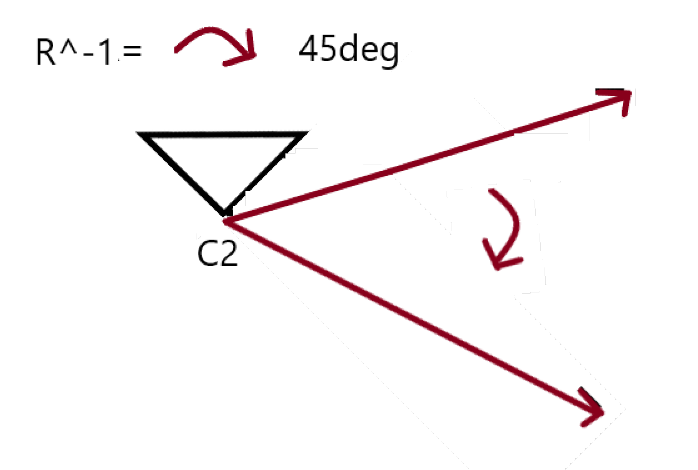

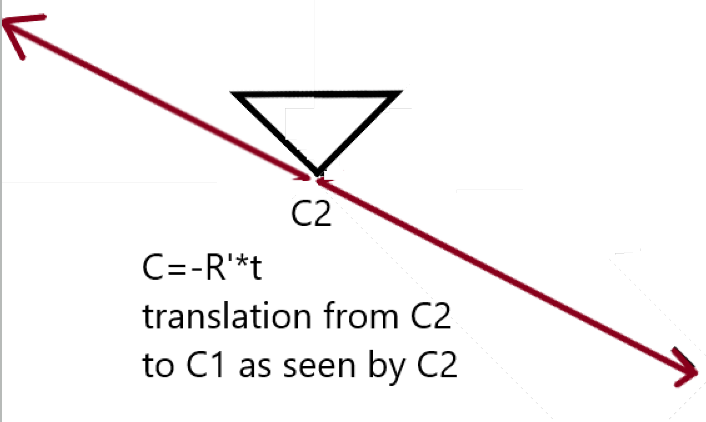

In [11]:


def compute_epipole(F):
    """ Computes the (right) epipole from a 
        fundamental matrix F. 
        (Use with F.T for left epipole.) """
    
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

def compute_P_from_fundamental(F):
    """    Computes the second camera matrix (assuming P1 = [I 0]) 
        from a fundamental matrix. """
        
    e = compute_epipole(F.T) # left epipole
    Te = skew(e)
    return np.vstack((np.dot(Te,F.T).T,e)).T
print "probably the epiole is in 2D coordinaes"
print "\n\n\n P2 computed directlt from the F"
print compute_P_from_fundamental(F.T)

print "\n\n\n P2 computed by computin C and R and by triangulation and disambiguation"
P2 = K.dot(np.insert(R, 3, -(R.dot(C[:,0])), axis=1))######################################
print P2
print "\n\n\n P2 computed by computin C and R and by triangulation and disambiguation and normalised by P(2,3)"
P2 = P2 / P2[2,3]
print P2
print "here only the C matrix is correct I think"

print "\n\n\n P2_v2 computed by computin C and R and by triangulation and disambiguation and normalised by P2_v2(2,3)"
P2_v2 = P2_v2 / P2_v2[2,3]
print P2_v2
print "here only the C matrix is correct I think"

probably the epiole is in 2D coordinaes



 P2 computed directlt from the F
[[   2.3452    1.9288 -627.4296 -248.5098]
 [   0.9289    0.764  -248.5083  627.4412]
 [   0.0016   -0.0025    1.973     1.    ]]



 P2 computed by computin C and R and by triangulation and disambiguation
[[ 439.0603    8.05    737.9957  132.361 ]
 [ -96.5427  569.2444  467.82   -334.1874]
 [  -0.1864    0.0006    0.9825   -0.5326]]



 P2 computed by computin C and R and by triangulation and disambiguation and normalised by P(2,3)
[[ -824.3413   -15.114  -1385.5965  -248.5095]
 [  181.2601 -1068.7638  -878.3382   627.4411]
 [    0.35      -0.0012    -1.8446     1.    ]]
here only the C matrix is correct I think



 P2_v2 computed by computin C and R and by triangulation and disambiguation and normalised by P2_v2(2,3)
[[ -824.3413   -15.114  -1385.5965  -248.5095]
 [  181.2601 -1068.7638  -878.3382   627.4411]
 [    0.35      -0.0012    -1.8446     1.    ]]
here only the C matrix is correct I think


In [12]:
import numpy as np
from scipy.linalg import expm

def rot_euler(v, xyz):
    ''' Rotate vector v (or array of vectors) by the euler angles xyz '''
    # https://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector
    for theta, axis in zip(xyz, np.eye(3)):
        v = np.dot(np.array(v), expm(np.cross(np.eye(3), axis*-theta)))
    return v

default_orientation = np.array([[0],[0],[1]])
rotated_orientation = R2.dot(default_orientation) * 10
print rotated_orientation

[[ 1.864 ]
 [-0.0313]
 [ 9.8247]]


In [13]:
def move_view(event):
            ax.autoscale(enable=False, axis='both')  # I have no idea, it this line have some effect at all
            ## Set nearly similar speed of motion in dependency on zoom
            if view_2D:
                koef = 4.  ## Speed for 2D should be higher
            else:
                koef = 8.  ## speed for 3D should be lower
                zkoef = (ax.get_zbound()[0] - ax.get_zbound()[1]) / koef

            xkoef = (ax.get_xbound()[0] - ax.get_xbound()[1]) / koef
            ykoef = (ax.get_ybound()[0] - ax.get_ybound()[1]) / koef

            ## Map an motion to keyboard shortcuts
            if event.key == "ctrl+down":
                ax.set_ybound(ax.get_ybound()[0] + xkoef, ax.get_ybound()[1] + xkoef)
            if event.key == "ctrl+up":
                ax.set_ybound(ax.get_ybound()[0] - xkoef, ax.get_ybound()[1] - xkoef)
            if event.key == "ctrl+right":
                ax.set_xbound(ax.get_xbound()[0] + ykoef, ax.get_xbound()[1] + ykoef)
            if event.key == "ctrl+left":
                ax.set_xbound(ax.get_xbound()[0] - ykoef, ax.get_xbound()[1] - ykoef)
            if not view_2D:
                if event.key == "down":
                    ax.set_zbound(ax.get_zbound()[0] - zkoef, ax.get_zbound()[1] - zkoef)
                if event.key == "up":
                    ax.set_zbound(ax.get_zbound()[0] + zkoef, ax.get_zbound()[1] + zkoef)
            # print event.key

        

<IPython.core.display.Javascript object>


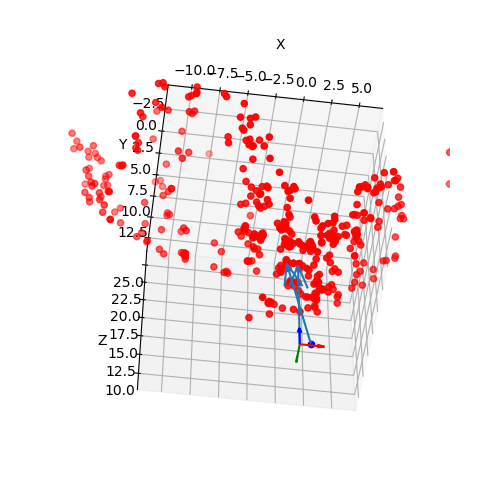

In [14]:
from matplotlib import pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", move_view)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-20,15) #same range -> 35
ax.set_ylim(-13,22) #same range -> 35
ax.set_zlim(0  ,35) #same range -> 35
#                   -> same scale for all


xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
ax.scatter(xs,ys,zs,  c='r')

#camera1
x = 0
y = 0
z = 0
xo = 0
yo = 0
zo = 10
ax.quiver(x,y,z,xo,yo,zo)

#camera2
x = -C[0,0]
y = C[1,0]
z = C[2,0]
xo = -rotated_orientation[0,0]
yo = rotated_orientation[1,0]
zo = rotated_orientation[2,0]
ax.scatter(x,y,z,  c='b')
ax.quiver(x,y,z,xo,yo,zo)

#x y z axes
ax.quiver(0,0,0,2,0,0, colors='r')
ax.quiver(0,0,0,0,2,0, colors='g')
ax.quiver(0,0,0,0,0,2, colors='b')
plt.show()

In [481]:
#as from matlab File LinearPnP.m from coursera assignement

def compute_P_as_Matlab(x,X):
    """    Compute camera matrix from pairs of
        2D-3D correspondences (in homog. coordinates). """

    n = x.shape[0]
    if X.shape[0] != n:
        raise ValueError("Number of points don't match.")
        
    # create matrix for DLT solution
    M = np.zeros((3*n,12))
    for i in range(n):
        M[i*3, 4:8] = -X[i,:]
        M[i*3, 8:12] = x[i,1] * X[i,:]
        M[i*3+1, 0:4] = X[i,:]
        M[i*3+1, 8:12] = -x[i,0] * X[i,:]
        M[i*3+2,0:4] = -x[i,1] * X[i,:]
        M[i*3+2,4:8] = x[i,0] * X[i,:]
        
        
    U,S,V = np.linalg.svd(M)
    V = V.T
    P = np.reshape(V[:,-1], (4,3), 'F').T #fucking column major, what the fucKKK!!!?? look into matlab implementation
    return (P/P[-1,-1])

def getCAndR(X,x, K):
    vector_of_ones  = np.ones((x.shape[0],))
    x = np.insert(x, 2, vector_of_ones ,axis = 1).T
    #x = np.dot(np.linalg.inv(K), x).T #thats the formula from matlab
    x = np.dot(np.linalg.pinv(K), x).T #thats the formula from matlab
    
    x = x[:,:-1]#remove last homogeneous column
    P = compute_P_as_Matlab(x,X)
    print "the P is a bit different because in matlab np.dot(np.linalg.inv(K), x).T is actually done with pseudo inv"
    print "but not because pf that aparently"

    R = P[:,:-1]
    C = P[:,3]
    
    U,S,V = np.linalg.svd(R)
    if np.linalg.det(U.dot(V)) > 0:
        R = U.dot(V)
        C = C / S[0]
        print "ttttttt", C
        
    else:
        R = (-U).dot(V)
        C = (-C)/S[0]
        print "tttttttqqqqqqqqqqq", C
    
    C = (-(R.T)).dot(C)
    return C,R


C_,R_ = getCAndR(X,x1, K)
print "C should be zeros(3) and R should be eye(3), but because of the noise when computing triangulation of X, these are not actually like that"
print R_
print C_

C_,R_ = getCAndR(X,x2,K)
print "\n\nC should be ... and R ... should be, but because of the noise when computing triangulation of X, these are not actually like that"
print "C2", C2
print "R2", R2
print "computed 3d to 2d coresponences"
print R_
print C_
    

the P is a bit different because in matlab np.dot(np.linalg.inv(K), x).T is actually done with pseudo inv
but not because pf that aparently
ttttttt [-0.0079 -0.0032  0.0047]
C should be zeros(3) and R should be eye(3), but because of the noise when computing triangulation of X, these are not actually like that
[[ 1.      0.0019  0.0002]
 [-0.0019  1.      0.0009]
 [-0.0002 -0.0009  1.    ]]
[ 0.0079  0.0033 -0.0047]
the P is a bit different because in matlab np.dot(np.linalg.inv(K), x).T is actually done with pseudo inv
but not because pf that aparently
tttttttqqqqqqqqqqq [ 0.8416 -0.137  -0.5351]


C should be ... and R ... should be, but because of the noise when computing triangulation of X, these are not actually like that
C2 [[-0.9211]
 [ 0.129 ]
 [ 0.3673]]
R2 [[ 0.9824  0.0134  0.1864]
 [-0.0131  0.9999 -0.0031]
 [-0.1864  0.0006  0.9825]]
computed 3d to 2d coresponences
[[ 0.9824  0.0115  0.1862]
 [-0.0112  0.9999 -0.0032]
 [-0.1862  0.001   0.9825]]
[-0.928   0.1279  0.3686]


http://www.uio.no/studier/emner/matnat/its/UNIK4690/v16/forelesninger/lecture_5_2_pose_from_known_3d_points.pdf
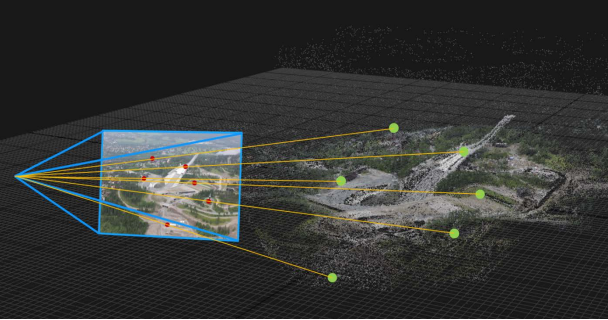

<IPython.core.display.Javascript object>


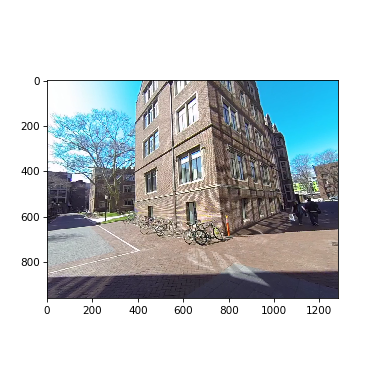

In [482]:
fig = plt.figure()
plt.imshow(img1)

<IPython.core.display.Javascript object>


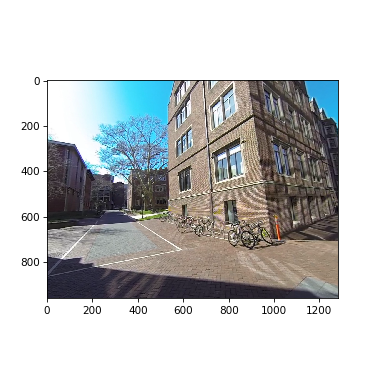

(960L, 1280L, 3L)


In [406]:
fig = plt.figure()
print img2.shape
plt.imshow(img2)

<IPython.core.display.Javascript object>


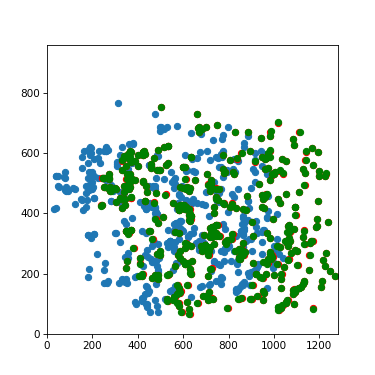

In [483]:
x_projected = P2.dot(X.T)
x_projected = x_projected / x_projected[[2],:]


fig = plt.figure()
plt.xlim(0,1280)
plt.ylim(0,960)
plt.scatter(x1[:,0],x1[:,1])
plt.scatter(x2[:,0],x2[:,1],c='r')
plt.scatter(x_projected[0,:],x_projected[1,:],c='g')

In [546]:
from math import sin, cos

def RotY(deg):
    return np.array([[cos(deg),  0, sin(deg)],
                     [    0   ,  1,   0    ],
                     [-sin(deg), 0, cos(deg)]])

deg = 0.785398 #radians 45
deg =-0.349066 #radians -20
deg =-0.436332 #radians -25
deg = -0.785398 #radians -45
#create new camera matrix
C3 = np.array([[10, 0, 0]]).T
R3 = RotY(deg)

t3 = -(R3.dot(C3))
P3 = K.dot(np.hstack((R3,t3)))


<IPython.core.display.Javascript object>


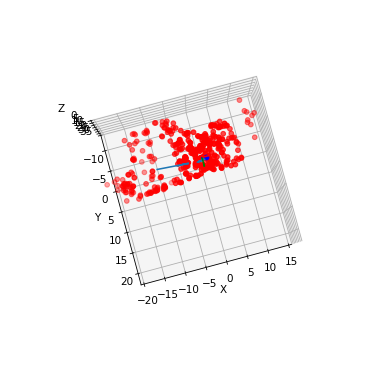

In [556]:
from matplotlib import pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", move_view)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-20,15) #same range -> 35
ax.set_ylim(-13,22) #same range -> 35
ax.set_zlim(0  ,35) #same range -> 35
#                   -> same scale for all


xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
ax.scatter(xs,ys,zs,  c='r')

#camera1
x = 0
y = 0
z = 0
xo = 0
yo = 0
zo = 10
ax.quiver(x,y,z,xo,yo,zo)

#camera2
x = -C[0,0]
y = C[1,0]
z = C[2,0]
xo = -rotated_orientation[0,0]
yo = rotated_orientation[1,0]
zo = rotated_orientation[2,0]
ax.scatter(x,y,z,  c='b')
ax.quiver(x,y,z,xo,yo,zo)

#camera3

x = -C3[0,0]
y = C3[1,0]
z = C3[2,0]
default_orientation = np.array([[0],[0],[1]])
rotated_orientation3 = R3.dot(default_orientation) * 10
xo = -rotated_orientation3[0,0]
yo = rotated_orientation3[1,0]
zo = rotated_orientation3[2,0]
ax.quiver(x,y,z,xo,yo,zo)


#x y z axes
ax.quiver(0,0,0,2,0,0, colors='r')
ax.quiver(0,0,0,0,2,0, colors='g')
ax.quiver(0,0,0,0,0,2, colors='b')
plt.show()

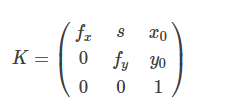

<IPython.core.display.Javascript object>


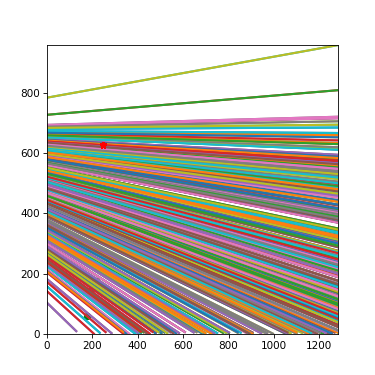

Because of the offset that the camera matrix induces, the result looks like this


In [559]:
x_projected = P3.dot(X.T)
x_projected = x_projected / x_projected[[2],:]


fig = plt.figure()
plt.xlim(0,1280)
plt.ylim(0,960)
#plt.scatter(x1[:,0],x1[:,1])
#plt.scatter(x2[:,0],x2[:,1],c='r')
plt.scatter(x_projected[0,:],x_projected[1,:],c='g')
print "Because of the offset that the camera matrix induces, the result looks like this"

In [686]:
def getLeftNullSpace(F_prime):
    A = F_prime
    rank = np.linalg.matrix_rank(A)
    U, s, V = np.linalg.svd(A, full_matrices = True)
    t_U_A = np.transpose(U)
    nrow = t_U_A.shape[0]
    left_null_A = t_U_A[rank:nrow,:]
    #print np.dot((left_null_A[0,:] + left_null_A[0,:]), A)
    return left_null_A/left_null_A[0,2]

def getRightNullSpace(F_prime):
    A = F_prime
    B = np.transpose(A)
    rank = np.linalg.matrix_rank(B)
    U, s, V = np.linalg.svd(B, full_matrices = True)
    t_V_B = np.transpose(V)
    ncols = t_V_B.shape[1]
    right_null_B = t_V_B[:,rank:ncols]
    #print np.dot(B, (right_null_B[:,0] + right_null_B[:,0]))
    return right_null_B/right_null_B[2,0]

def epipoleSVD(M):
    V = cv2.SVDecomp(M)[2]
    return V[-1]/V[-1,-1]

print epipoleSVD(E2)
print epipoleSVD(E2.T)
print epipoleSVD(F)
print epipoleSVD(F.T)

print "\n\n\n These small values are actually the values in 3D of the epipoles. So when you get epipole from F you get in 2D, when you get epipole from E you get in 3D"
print getLeftNullSpace(E)
print getRightNullSpace(E.T)
print getLeftNullSpace(E.T)
print getRightNullSpace(E)

print "\n\n\n"
print getLeftNullSpace(F)
print getRightNullSpace(F.T)
print getLeftNullSpace(F.T)
print getRightNullSpace(F)

[-1.5672  0.2627  1.    ]
[-2.5082  0.3513  1.    ]
[-248.5098  627.4412    1.    ]
[-783.9227  677.895     1.    ]



 These small values are actually the values in 3D of the epipoles. So when you get epipole from F you get in 2D, when you get epipole from E you get in 3D
[[-2.5082  0.3513  1.    ]]
[[-1.5672]
 [ 0.2627]
 [ 1.    ]]
[[-1.5672  0.2627  1.    ]]
[[-2.5082]
 [ 0.3513]
 [ 1.    ]]




[[-783.9227  677.895     1.    ]]
[[-248.5098]
 [ 627.4412]
 [   1.    ]]
[[-248.5098  627.4412    1.    ]]
[[-783.9227]
 [ 677.895 ]
 [   1.    ]]


[-248.5095  627.4411    1.    ]
[-783.9222  677.8946    1.    ]





[-1.5672  0.2627  1.    ]
[-2.5082  0.3513  1.    ]
[ 0.9211 -0.129  -0.3673]
or  [-0.9211  0.129   0.3673]
as described in epipolar geometry 3 coursera minute 6:31, ambiguity of scale
ok, so apparently  [-0.9211  0.129   0.3673] 
 is the same as C2 camera computed using triangulation [[-0.9211]
 [ 0.129 ]
 [ 0.3673]]
that means that -compute_epipole_from_E(E2) is the coordinate in the first camera system orientation: I and 0

compute_epipole_from_E(E2.T) is the first camera position as seen from the system coordinate of the second camera, so in order to bring that back to I and 0 I should apply a transformation
the transformation should be R.inv * v - t
[-0.  0. -0.]


<IPython.core.display.Javascript object>


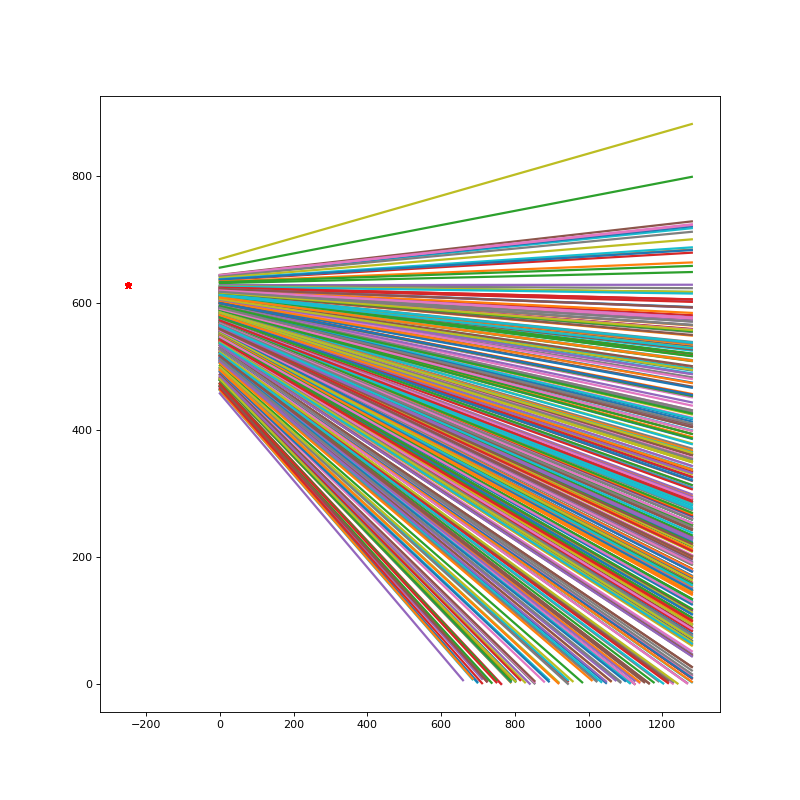

In [707]:
def compute_epipole(F):
    """ Computes the (right) epipole from a 
        fundamental matrix F. 
        (Use with F.T for left epipole.) """
    
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

def compute_epipole_from_E(E):
    """ Computes the (right) epipole from a 
        essential matrix E. 
        (Use with E.T for left epipole.) """
    ###########################################
    ###########################################
    ###########################################
    #taken from Epipolar Geometry 3 minute 5:58
    U,S,V = np.linalg.svd(E)
    #S is (1,1,0)
    e = U[:,-1]
    
    return e # here i dont have to normalize it /e[2]

def plot_epipolar_line(im,F,x,epipole=None,show_epipole=True):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = np.dot(F,x)
    line = np.squeeze(line)
    
    # epipolar line parameter and values
    t = np.linspace(0,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m)
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')
        

print compute_epipole(F2)
print compute_epipole(F2.T)

print "\n\n\n\n"
print compute_epipole(E2)
print compute_epipole(E2.T)
print compute_epipole_from_E(E2)
print "or ",-compute_epipole_from_E(E2)
t__ = -compute_epipole_from_E(E2)
print "as described in epipolar geometry 3 coursera minute 6:31, ambiguity of scale"
print  "ok, so apparently ", -compute_epipole_from_E(E2), "\n is the same as C2 camera computed using triangulation", C2
print "that means that -compute_epipole_from_E(E2) is the coordinate in the first camera system orientation: I and 0"

print "\ncompute_epipole_from_E(E2.T) is the first camera position as seen from the system coordinate of the second camera, so in order to bring that back to I and 0 I should apply a transformation"
print "the transformation should be R.inv * v - t"
c__ = compute_epipole_from_E(E2.T)
print np.linalg.inv(R2).dot(c__) - t__

############################################################################################
###########################################################################################
###########################################################################################
#https://www.coursera.org/learn/robotics-perception/lecture/WRyoL/epipolar-geometry-ii
#minute 12:45 explains better
#also minute 13:24 says how to get epipole from F
############################################################################################
############################################################################################
############################################################################################
epipole = getRightNullSpace(F.T)
fig = plt.figure()
for i in range(len(x1)):
    x = np.array([[x1[i][0], x1[i][1], 1]]).T
    plot_epipolar_line(img2,F2.T,x,epipole=epipole,show_epipole=True)

In [ ]:
#epipolar geometry 3
#you can also compute R from essential matrix using the formula from minute 10:46
# and you actuallt have two ways of computin R
# two ways of computin t
# thus 4 ways of computing the camera matrix P

<IPython.core.display.Javascript object>


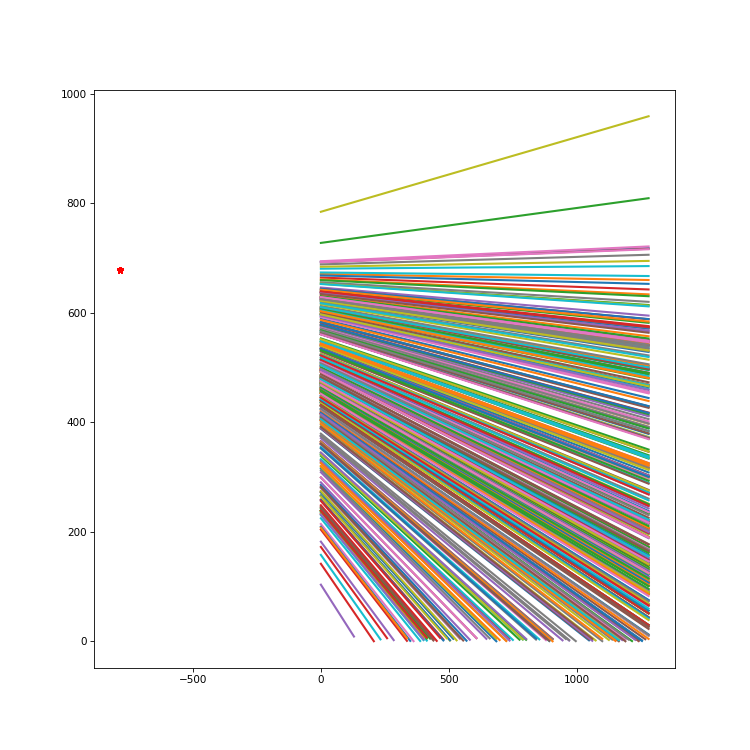

In [662]:
epipole = getLeftNullSpace(F).T
fig = plt.figure()
for i in range(len(x1)):
    x = np.array([[x1[i][0], x1[i][1], 1]]).T
    plot_epipolar_line(img2,F2,x,epipole=epipole,show_epipole=True)

In [606]:


print getLeftNullSpace(E2)
print getRightNullSpace(E2.T)
print compute_epipole(E2)
print compute_epipole(np.linalg.inv(F2))

[[-783.9227  677.895     1.    ]]
[[-248.5098]
 [ 627.4412]
 [   1.    ]]
[[-2.5082  0.3513  1.    ]]
[[-1.5672]
 [ 0.2627]
 [ 1.    ]]
[-248.5098  627.4412    1.    ]
[-248.5098  627.4412    1.    ]


<IPython.core.display.Javascript object>


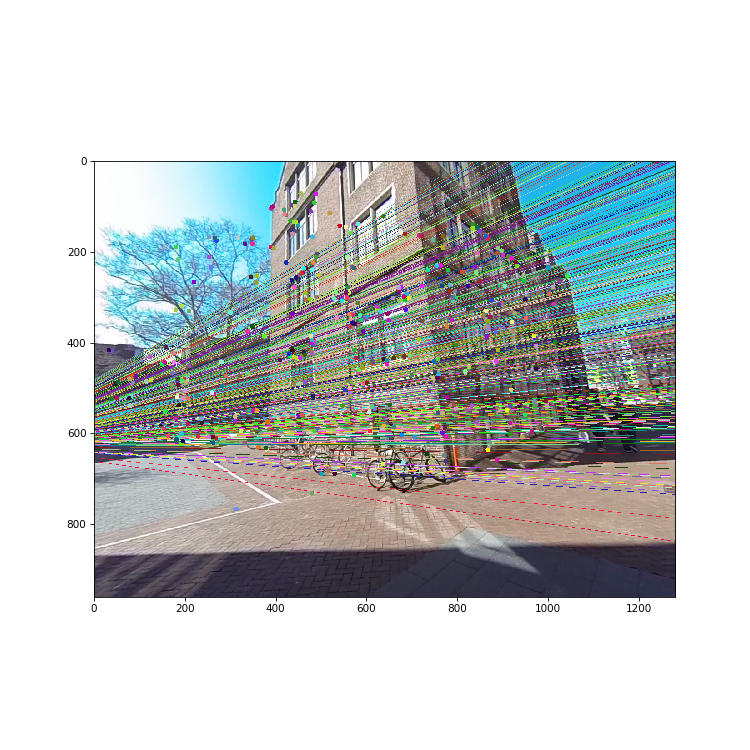

In [651]:

#http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,ch = img1.shape
    #img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    #img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        pt1 = pt1.astype(np.int32)
        pt2 = pt2.astype(np.int32)
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

import cv2
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
pts2 = x2
pts1 = x1
# if not the below two lines then, Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)
#img1 = np.array(img1, dtype=np.uint8)
#img2 = np.array(img2, dtype=np.uint8)
img1 = np.ascontiguousarray(img1, dtype=np.uint8)
img2 = np.ascontiguousarray(img2, dtype=np.uint8)
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F2)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F2)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
plt.imshow(img5)


plt.show()

<IPython.core.display.Javascript object>


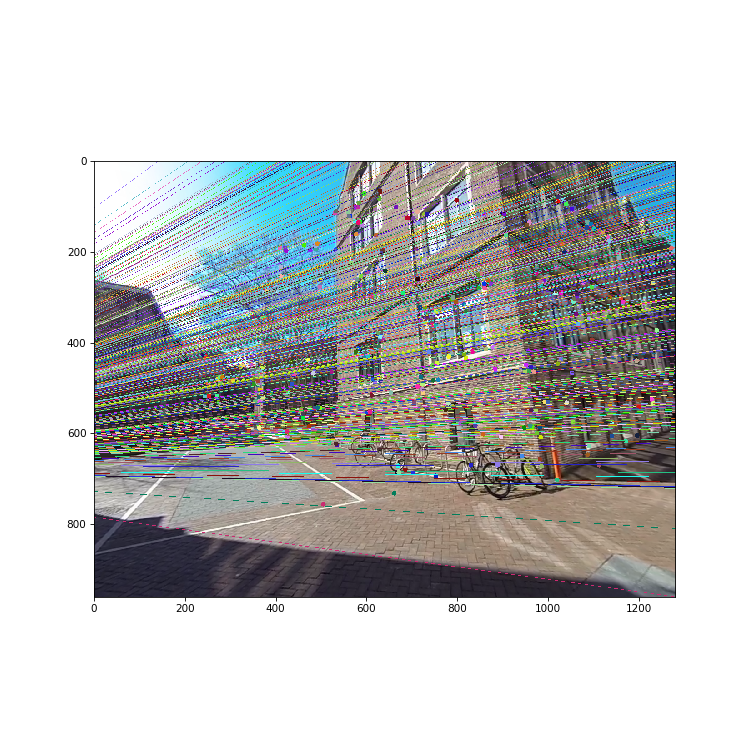

In [650]:
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
plt.imshow(img3)
plt.show()

In [675]:
F_CV, mask = cv2.findFundamentalMat(pts2,pts1,cv2.FM_8POINT)
print F2
print F_CV

[[ 0.     -0.      0.0026]
 [ 0.     -0.      0.0015]
 [-0.0037 -0.0031  1.    ]]
[[ 0.     -0.      0.0024]
 [ 0.     -0.      0.0018]
 [-0.0036 -0.0034  1.    ]]


In [ ]:
############################################################################################################################################################
##################################################################################################################################
############################################################################################################################################################
##################################################################################################################################
############################################################################################################################################################
##################################################################################################################################
############################################################################################################################################################
##################################################################################################################################
The reason why I need to apply -x when plotting 3d is because the y increases when it goes up in 3d
while in 2d image, y decreases when it goes up. Thus, the result is mirrored